In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
import torch
import nltk
from nltk.tokenize import word_tokenize 
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm

c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
corpus = pd.read_csv('C:\\Users\\Vitaliy\\OneDrive\\Рабочий стол\\классификация текста\\APPLE_iPhone_SE.csv')

In [4]:
corpus

,Ratings,Comment,Reviews
0,5,Super!,Great camera for pics and videos Battery life ...
1,5,Must buy!,Great device. Let me tell the Pros..1. Superb ...
2,5,Great product,"Who all loves older size i.e., 4.7 inch type s..."
3,5,Simply awesome,This iPhone SE is the best phone ever you get....
4,5,Classy product,This is my second iphone after iphone 4s. I’ve...
...,...,...,...
9708,5,Terrific purchase,Absolutely brilliantREAD MORE
9709,5,Classy product,"Superb phone. This is my 4th iPhone, I feel SE..."
9710,5,Awesome,very niceREAD MORE
9711,5,Super!,Loving it as of now. Good Product .READ MORE


In [5]:
corpus.Reviews.iloc[1000]

"Really superb.. Awesome it's my Genuine FeedbackREAD MORE"

удалим READ MORE из Reviews

In [6]:
def delete(x):
    x = x.replace('READ MORE', '')
    return x

corpus['Reviews'] = corpus.Reviews.apply(lambda x: delete(x))

разделим на train, validation, test

In [7]:
X = corpus.drop(['Ratings'], axis=1)
y = corpus.Ratings

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [8]:
X_train.Reviews.iloc[150]

'Good phone for its price. Camera performs great with good lighting.'

In [9]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vitaliy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vitaliy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
bag_of_words = Counter()

обработаем тексты

In [11]:
def text_preprocessing(x):
    global bag_of_words

    x = x.replace('READ MORE', '')
    x_token = word_tokenize(x)
    for elem in x_token:
        if elem not in stop_words:
            x = lemmatizer.lemmatize(elem)
            
            if x in bag_of_words:
                bag_of_words[x] += 1
            else:
                bag_of_words[x] = 1

In [12]:
corpus.Comment.apply(lambda x: text_preprocessing(x))
corpus.Reviews.apply(lambda x: text_preprocessing(x))

0       None
1       None
2       None
3       None
4       None
        ... 
9708    None
9709    None
9710    None
9711    None
9712    None
Name: Reviews, Length: 9713, dtype: object

Удалим редко встречающиеся слова (по желанию)

In [13]:
flag = False
treshold = 5

if flag:
    words = set()

    for word in bag_of_words:
        if bag_of_words[word] >= treshold:
            words.add(word)

Также добавим токены начала и конца предложения и неизвестный токен

In [14]:
bag_of_words['unk'] = 1
bag_of_words['bos'] = 1
bag_of_words['eos'] = 1
bag_of_words['pad'] = 1

In [15]:
len(bag_of_words)

10620

составим словари word2idx и idx2word

In [16]:
word2idx = {word: idx for idx, word in enumerate(bag_of_words)}
idx2word = {word2idx[word] : word for word in word2idx} 

определим даталодер для обоих текстов

In [17]:
class Dataset:
    def __init__(self, data_text, data_label, bag_of_words):
        self.data = data_text
        self.data_r = data_text['Reviews']
        self.data_c = data_text['Comment']
        self.labels = data_label
        self.unk = word2idx['unk']
        self.bos = word2idx['bos']
        self.eos = word2idx['eos']
        self.bag_of_words = bag_of_words

    def __getitem__(self, idx):
        mas1 = [self.bos]
        mas2 = [self.bos]

        for word in word_tokenize(self.data_c.iloc[idx]):
            if not word in stop_words:
                word = lemmatizer.lemmatize(word)
                if word in self.bag_of_words:
                    mas1.append(word2idx[word])
                else:
                    mas1.append(self.unk)
        mas1.append(self.eos)
        #--------------------------------------------
        for word in word_tokenize(self.data_r.iloc[idx]):
            if not word in stop_words:
                word = lemmatizer.lemmatize(word)
                if word in self.bag_of_words:
                    mas2.append(word2idx[word])
                else:
                    mas2.append(self.unk)
        mas2.append(self.eos)
        
        sample = {
            'text_c' : mas1,
            'text_r' : mas2,
            'label' : self.labels.iloc[idx]
        }
        return sample


    def __len__(self):
        return len(self.data)


In [18]:
dataset_train = Dataset(X_train, y_train, bag_of_words)
dataset_val = Dataset(X_val, y_val, bag_of_words)
dataset_test = Dataset(X_test, y_test, bag_of_words)


In [19]:
def collate_function(batch, max_length = 100):
    len_sentences_c = [len(seq['text_c']) for seq in batch]
    max_length_c = min(max(len_sentences_c), max_length)

    len_sentences_r = [len(seq['text_r']) for seq in batch]
    max_length_r = min(max(len_sentences_r), max_length)

    collate = []
    for seq in batch:
        while len(seq['text_c']) < max_length_c:
            seq['text_c'].append(word2idx['pad'])
        if len(seq['text_c']) > max_length_c:
            seq['text_c'] = seq['text_c'][:100]
        collate.append(seq['text_c'])
    #---------------------------------------------------
    collate2 = []
    for seq in batch:
        while len(seq['text_r']) < max_length_r:
            seq['text_r'].append(word2idx['pad'])
        if len(seq['text_r']) > max_length_r:
            seq['text_r'] = seq['text_r'][:100]
        collate2.append(seq['text_r'])


    collate = torch.LongTensor(collate)
    collate2 = torch.LongTensor(collate2)
    labels = torch.LongTensor([seq['label'] - 1 for seq in batch])

    sample = {
            'text_c' : collate,
            'text_r' : collate2,
            'label' : labels
        }

    return sample

        

In [20]:
batch_size = 32

train_dataloader = DataLoader(dataset_train, collate_fn = collate_function, batch_size=batch_size)
val_dataloader = DataLoader(dataset_val, collate_fn = collate_function, batch_size=batch_size)
test_dataloader = DataLoader(dataset_test, collate_fn = collate_function, batch_size=batch_size)

Определим модель

In [58]:
class Model(nn.Module):
    def __init__(self, vocab, hidden_dim = 100, len_sentences = 100, rate=5):
        super().__init__()
        
        self.embedding = nn.Embedding(len(vocab), hidden_dim)
        self.rnn = nn.LSTM(len_sentences, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, rate)
        self.linear2 = nn.Linear(rate, rate)
        self.droput = nn.Dropout(0.1)
        self.relu = nn.ReLU()


    def forward(self, inp_batch):
        emb = self.embedding(inp_batch['text_c'])
        out, _ = self.rnn(emb)
        out = out.mean(dim=1)

        emb = self.embedding(inp_batch['text_r'])
        out2, _ = self.rnn(emb)
        out2 = out2.mean(dim=1)

        out = self.droput(self.relu(self.linear(out)))
        out2 = self.droput(self.relu(self.linear(out2)))

        pred = out + out2
        #pred = self.droput(self.relu(self.linear2(pred)))
        return pred

In [59]:
model = Model(bag_of_words)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['pad'])
optimizer = torch.optim.Adam(model.parameters())

реализуем обучение модели

In [60]:
def evaluate(dataloader, model):
    loss_mas = []
    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch)
            loss = criterion(pred, batch['label'])
            loss_mas.append(loss.item())

    return np.mean(loss_mas)


In [61]:
epochs = 5

loss_epochs = []
loss_eval = []

for epoch in tqdm(range(epochs)):
    loss_mas = []
    for batch in train_dataloader:
        optimizer.zero_grad()
        pred = model(batch)
        loss = criterion(pred, batch['label'])
        loss_mas.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f'loss epoch = {np.mean(loss_mas)}')
    loss_epochs.append(np.mean(loss_mas))

    val_loss = evaluate(val_dataloader, model)
    print(f'val_loss epoch = {np.mean(val_loss)}')
    loss_eval.append(np.mean(val_loss))

  0%|          | 0/5 [00:00<?, ?it/s]

loss epoch = 0.6301107729824496


 20%|██        | 1/5 [00:14<00:59, 14.95s/it]

val_loss epoch = 0.3212474446905696
loss epoch = 0.22637484880260458


 40%|████      | 2/5 [00:29<00:44, 14.81s/it]

val_loss epoch = 0.19547111808281878
loss epoch = 0.17727296091965947


 60%|██████    | 3/5 [00:46<00:31, 15.81s/it]

val_loss epoch = 0.19487767488412236
loss epoch = 0.16079329667796552


 80%|████████  | 4/5 [01:05<00:17, 17.13s/it]

val_loss epoch = 0.21220477779760308
loss epoch = 0.14709646837947618


100%|██████████| 5/5 [01:25<00:00, 17.07s/it]

val_loss epoch = 0.23735657725078257


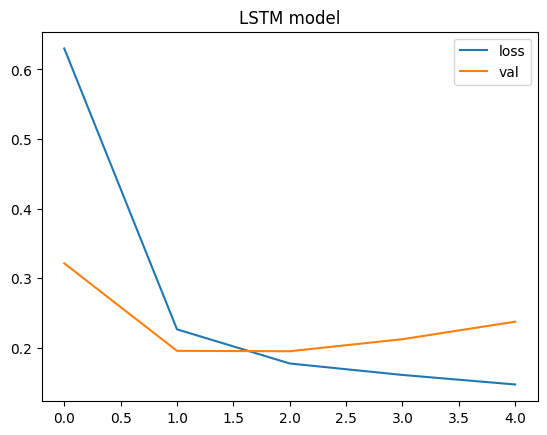

In [65]:
plt.plot(loss_epochs, label='loss')
plt.plot(loss_eval, label='val')
plt.legend()
plt.title("LSTM model")
plt.show()

посчитаем точность 

In [63]:
def accuracy_multiclass(test_dataloader, model):
    with torch.no_grad():
        mas = []
        for batch in test_dataloader:
                pred = model(batch)
                pred = [np.argmax(elem) for elem in pred]
                mas.append([pred, batch['label']])


    cnt = 0
    true = 0
    for i in range(len(mas)):
        for j in range(len(mas[i][0])):
            if mas[i][0][j] == mas[i][1][j]:
                true += 1
            cnt += 1
    return true / cnt

In [64]:
accuracy_multiclass(test_dataloader, model)

0.9416609471516816